In [1]:
import numpy as np
import matplotlib.pyplot as plt
from epymorph.data.ipm.sirh import SIRH
from epymorph.data.mm.no import No
from epymorph.geography.us_census import StateScope
from epymorph.initializer import Proportional
from epymorph.rume import SingleStrataRUME
from epymorph.time import TimeFrame
from epymorph.parameter_fitting.likelihood import Poisson
from epymorph.time import ByEpiWeek
from epymorph.attribute import NamePattern
from epymorph.adrio.cdc import InfluenzaStateHospitalization
from epymorph.simulation import Context
from epymorph.forecasting.dynamic_params import GaussianPrior, OrnsteinUhlenbeck
from epymorph.forecasting.pipeline import (
    UnknownParam,
)
from epymorph.forecasting.pipeline import (
    ForecastSimulator,
    FromRUME,
    ParticleFilterSimulator,
    Observations,
    ModelLink,
)
from epymorph.adrio import acs5
from epymorph.forecasting.param_transformations import ExponentialTransform
from epymorph.geography.scope import GeoGrouping
import datetime
from epymorph.time import date


class ByNode(GeoGrouping):
    def map(self, node_ids):
        return node_ids.copy()


class NoGrouping(GeoGrouping):
    def __init__(self, group_name="all"):
        self.group_name = "all"

    def map(self, node_ids):
        return np.broadcast_to(np.array([self.group_name]), node_ids.shape)


my_rng = np.random.default_rng(1)

num_realizations = 200

# 2023-2024 Season
flusight_start_date = "2023-10-08"  # The Sunday of the first epiweek to forecast.
flusight_weeks = 30
burn_in_weeks = 20
forecast_horizon = 3

assert date.fromisoformat(flusight_start_date).weekday() == 6

simulation_start_date = date.fromisoformat(flusight_start_date) + datetime.timedelta(
    days=-7 * burn_in_weeks
)
simulation_duration = 7 * (burn_in_weeks + flusight_weeks + forecast_horizon)
simulation_time_frame = TimeFrame.of(simulation_start_date, simulation_duration)

my_scope = StateScope.in_states(["AZ", "CO", "NM", "UT"], year=2015)
# my_scope = StateScope.all(year=2015)

my_rume = SingleStrataRUME.build(
    ipm=SIRH(),
    mm=No(),
    scope=my_scope,
    init=Proportional(
        ratios=np.broadcast_to(
            np.array([500, 1, 100, 0], dtype=np.int64), shape=(my_scope.nodes, 4)
        )
    ),
    time_frame=simulation_time_frame,
    params={
        "beta": ExponentialTransform("log_beta"),
        "gamma": 1 / 5,
        "xi": 1 / 90,
        "hospitalization_prob": 150 / 100_000,
        "hospitalization_duration": 5.0,
        "population": acs5.Population(),
    },
)

log_beta_dynamics = OrnsteinUhlenbeck(
    damping=1 / 50, mean=np.log(0.19), standard_deviation=0.2
)

mu = log_beta_dynamics.mean
sig = log_beta_dynamics.standard_deviation
beta_mean = np.exp(mu + sig**2 / 2)
beta_standard_deviation = np.sqrt((np.exp(sig**2) - 1) * np.exp(2 * mu + sig**2))

print(beta_mean)
print(beta_standard_deviation)

forecast_initial_indices = np.array(
    [(burn_in_weeks + i) * 7 - 1 for i in range(flusight_weeks)]
)

start = datetime.date.fromisoformat(flusight_start_date)
forecast_start_dates = np.array(
    [(start + datetime.timedelta(i * 7)).isoformat() for i in range(flusight_weeks)]
)

0.1938382546050836
0.03915857753699422


In [2]:
my_rng = np.random.default_rng(0)
warm_up_sim = ForecastSimulator(
    config=FromRUME(
        rume=my_rume,
        num_realizations=num_realizations,
        unknown_params={
            "log_beta": UnknownParam(
                prior=GaussianPrior(
                    mean=log_beta_dynamics.mean,
                    standard_deviation=log_beta_dynamics.standard_deviation,
                ),
                # dynamics=log_beta_dynamics,
                dynamics=OrnsteinUhlenbeck(
                    damping=1 / 50, mean=np.log(0.19), standard_deviation=0.2
                ),
            ),
        },
    ),
    duration=50,
)
warm_up_out = warm_up_sim.run(rng=my_rng)

In [3]:
my_observations = Observations(
    source=InfluenzaStateHospitalization(),
    model_link=ModelLink(
        geo=my_rume.scope.select.all(),
        time=my_rume.time_frame.select.all().group(ByEpiWeek()).agg("sum"),
        quantity=my_rume.ipm.select.events("I->H"),
    ),
    likelihood=Poisson(),
)

In [4]:
my_unknown_params = {
    "log_beta": UnknownParam(
        prior=warm_up_out.final_param_values[NamePattern.of("log_beta")],
        dynamics=log_beta_dynamics,
    ),
}
my_initial_values = warm_up_out.final_compartment_values

# unknown_params={
#     "log_beta": UnknownParam(
#         prior=GaussianPrior(
#             mean=np.log(0.19),
#             standard_deviation=0.2,
#         ),
#         dynamics=OrnsteinUhlenbeck(
#             damping=1 / 50, mean=np.log(0.19), standard_deviation=0.2
#         ),
#     )
# }

pf_sim = ParticleFilterSimulator(
    config=FromRUME(
        rume=my_rume,
        num_realizations=num_realizations,
        unknown_params=my_unknown_params,
        initial_values=my_initial_values,
    ),
    observations=my_observations,
    duration=(burn_in_weeks + flusight_weeks) * 7,
    local_blocks=my_rume.scope.select.all().group(ByNode()),
    observation_mask=np.identity(my_rume.scope.nodes, dtype=bool),
)
pf_out = pf_sim.run(rng=my_rng)

Observation: 0, Label: 2023-21, Time Frame: 2023-05-21/2023-05-27 (7D)
Observation: 1, Label: 2023-22, Time Frame: 2023-05-28/2023-06-03 (7D)
Observation: 2, Label: 2023-23, Time Frame: 2023-06-04/2023-06-10 (7D)
Observation: 3, Label: 2023-24, Time Frame: 2023-06-11/2023-06-17 (7D)
Observation: 4, Label: 2023-25, Time Frame: 2023-06-18/2023-06-24 (7D)
Observation: 5, Label: 2023-26, Time Frame: 2023-06-25/2023-07-01 (7D)
Observation: 6, Label: 2023-27, Time Frame: 2023-07-02/2023-07-08 (7D)
Observation: 7, Label: 2023-28, Time Frame: 2023-07-09/2023-07-15 (7D)
Observation: 8, Label: 2023-29, Time Frame: 2023-07-16/2023-07-22 (7D)
Observation: 9, Label: 2023-30, Time Frame: 2023-07-23/2023-07-29 (7D)
Observation: 10, Label: 2023-31, Time Frame: 2023-07-30/2023-08-05 (7D)
Observation: 11, Label: 2023-32, Time Frame: 2023-08-06/2023-08-12 (7D)
Observation: 12, Label: 2023-33, Time Frame: 2023-08-13/2023-08-19 (7D)
Observation: 13, Label: 2023-34, Time Frame: 2023-08-20/2023-08-26 (7D)
Ob

In [5]:
import dataclasses


forecast_outputs = []
for i in range(flusight_weeks):
    print(f"Forecast {i} starting on {forecast_start_dates[i]}")

    initial_beta_values = pf_out.estimated_params[NamePattern.of("log_beta")][
        :, forecast_initial_indices[i] + 1, ...
    ]
    initial_compartment_values = pf_out.compartments[
        :, forecast_initial_indices[i] + 1, ...
    ]

    forecast_rume = dataclasses.replace(
        my_rume,
        time_frame=TimeFrame.of(
            forecast_start_dates[i], duration_days=forecast_horizon * 7
        ),
    )

    fct_sim = ForecastSimulator(
        config=FromRUME(
            rume=forecast_rume,
            num_realizations=num_realizations,
            unknown_params={
                "log_beta": UnknownParam(
                    prior=initial_beta_values,
                    dynamics=my_unknown_params["log_beta"].dynamics,
                ), 
            },
            initial_values=initial_compartment_values,
        ),
        duration=forecast_horizon * 7,
    )

    fct_out = fct_sim.run(rng=my_rng)
    forecast_outputs.append(fct_out)

Forecast 0 starting on 2023-10-08
Forecast 1 starting on 2023-10-15
Forecast 2 starting on 2023-10-22
Forecast 3 starting on 2023-10-29
Forecast 4 starting on 2023-11-05
Forecast 5 starting on 2023-11-12
Forecast 6 starting on 2023-11-19
Forecast 7 starting on 2023-11-26
Forecast 8 starting on 2023-12-03
Forecast 9 starting on 2023-12-10
Forecast 10 starting on 2023-12-17
Forecast 11 starting on 2023-12-24
Forecast 12 starting on 2023-12-31
Forecast 13 starting on 2024-01-07
Forecast 14 starting on 2024-01-14
Forecast 15 starting on 2024-01-21
Forecast 16 starting on 2024-01-28
Forecast 17 starting on 2024-02-04
Forecast 18 starting on 2024-02-11
Forecast 19 starting on 2024-02-18
Forecast 20 starting on 2024-02-25
Forecast 21 starting on 2024-03-03
Forecast 22 starting on 2024-03-10
Forecast 23 starting on 2024-03-17
Forecast 24 starting on 2024-03-24
Forecast 25 starting on 2024-03-31
Forecast 26 starting on 2024-04-07
Forecast 27 starting on 2024-04-14
Forecast 28 starting on 2024-0

In [6]:
one_wk = []
one_wk_dates = []
two_wk = []
two_wk_dates = []
three_wk = []
three_wk_dates = []
for i in range(len(forecast_outputs)):
    one_wk.append(forecast_outputs[i].events[:, 0 * 7 : 1 * 7, :, 1].sum(axis=1))
    two_wk.append(forecast_outputs[i].events[:, 1 * 7 : 2 * 7, :, 1].sum(axis=1))
    three_wk.append(forecast_outputs[i].events[:, 2 * 7 : 3 * 7, :, 1].sum(axis=1))
    one_wk_dates.append(
        (
            datetime.date.fromisoformat(forecast_start_dates[i]) + datetime.timedelta(7)
        ).isoformat()
    )
    two_wk_dates.append(
        (
            datetime.date.fromisoformat(forecast_start_dates[i])
            + datetime.timedelta(14)
        ).isoformat()
    )
    three_wk_dates.append(
        (
            datetime.date.fromisoformat(forecast_start_dates[i])
            + datetime.timedelta(21)
        ).isoformat()
    )

zero_wk = np.transpose(pf_out.posterior_values[burn_in_weeks:, ..., 0], axes=[1, 0, 2])
one_wk = np.transpose(np.array(one_wk), axes=[1, 0, 2])
two_wk = np.transpose(np.array(two_wk), axes=[1, 0, 2])
three_wk = np.transpose(np.array(three_wk), axes=[1, 0, 2])

In [7]:
context = Context.of(
    scope=my_rume.scope,
    time_frame=TimeFrame.of(flusight_start_date, (flusight_weeks + 2) * 7),
    rng=my_rng,
)
real_data = InfluenzaStateHospitalization().with_context_internal(context).inspect()

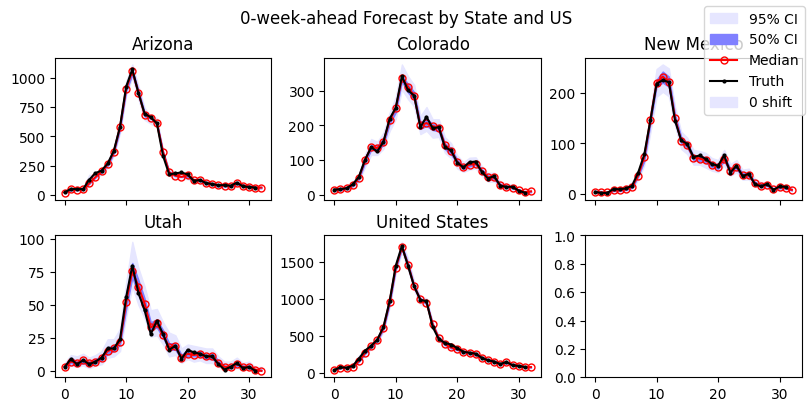

In [8]:
# nrows = 18
ncols = 3
nrows = int(np.ceil((my_rume.scope.nodes + 1) / ncols))
n_weeks_ahead = 0

us_node = my_rume.scope.nodes

if n_weeks_ahead == 0:
    forecast_samples = zero_wk
elif n_weeks_ahead == 1:
    forecast_samples = one_wk
    forecast_dates = one_wk_dates
elif n_weeks_ahead == 3:
    forecast_samples = two_wk
    forecast_dates = two_wk_dates
elif n_weeks_ahead == 3:
    forecast_samples = three_wk
    forecast_dates = three_wk_dates

fig, axs = plt.subplots(nrows=nrows, ncols=ncols, sharex=True)
fig.set_layout_engine("compressed")
fig.set_figwidth(8)
fig.set_figheight(8 * nrows / 4)
axs = np.ravel(np.array(axs))
for node in range(my_rume.scope.nodes + 1):
    if node == us_node:
        quantiles_values = np.quantile(
            forecast_samples.sum(axis=2),
            [0.025, 0.25, 0.50, 0.75, 0.975],
            axis=0,
        )
    else:
        quantiles_values = np.quantile(
            forecast_samples[..., node],
            [0.025, 0.25, 0.50, 0.75, 0.975],
            axis=0,
        )

    t = np.arange(quantiles_values.shape[1])
    axs[node].fill_between(
        t,
        quantiles_values[0, ...],
        quantiles_values[4, ...],
        color=[0.9, 0.9, 1],
    )
    axs[node].fill_between(
        t,
        quantiles_values[1, ...],
        quantiles_values[3, ...],
        color=[0.5, 0.5, 1],
    )
    axs[node].plot(
        t,
        quantiles_values[2, ...],
        color="red",
        marker="o",
        markersize=5,
        fillstyle="none",
    )

    # axs[node].plot(
    #     pf_out.observed_values[burn_in_weeks:burn_in_weeks+flusight_weeks, node, 0], color="k", marker="o", markersize=2
    # )

    if node == us_node:
        truth = real_data.result["value"].sum(axis=1)
    else:
        truth = real_data.result["value"][:, node]

    # if node == us_node:
    #     truth = data_numpy["value"][burn_in_weeks:, ...].sum(axis=1)
    # else:
    #     truth = data_numpy["value"][burn_in_weeks:][:, node]

    t = np.arange(truth.shape[0]) - n_weeks_ahead
    axs[node].plot(t, truth, color="k", linestyle="-", marker="o", markersize=2)
    # axs[node].plot(t+n_weeks_ahead, truth, color="k", marker="+", linestyle=':', markersize=5)

    if node == us_node:
        # axs[node].set_title("US")
        axs[node].set_title("United States")
    else:
        # axs[node].set_title(my_rume.scope.labels[node])
        axs[node].set_title(my_rume.scope.get_info()["NAME"][node])
fig.legend(["95% CI", "50% CI", "Median", "Truth", f"{n_weeks_ahead} shift"])
plt.suptitle(f"{n_weeks_ahead}-week-ahead Forecast by State and US")
plt.show()

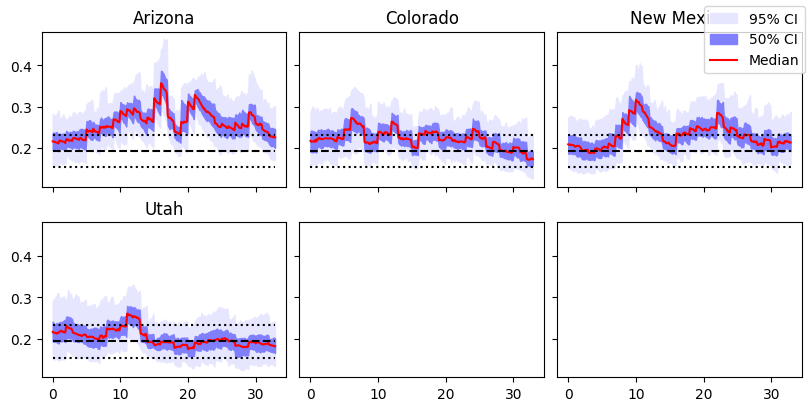

In [9]:
ncols = 3
nrows = int(np.ceil((my_rume.scope.nodes + 1) / ncols))

fig, axs = plt.subplots(nrows=nrows, ncols=ncols, sharex=True, sharey=True)
fig.set_layout_engine("compressed")
fig.set_figwidth(8)
fig.set_figheight(8 * nrows / 4)
axs = np.ravel(np.array(axs))
for node in range(my_rume.scope.nodes):
    quantiles_values = np.quantile(
        np.exp(
            pf_out.estimated_params[NamePattern.of("log_beta")][
                :, 7 * burn_in_weeks :, node
            ]
        ),
        [0.025, 0.25, 0.50, 0.75, 0.975],
        axis=0,
    )

    t = np.arange(quantiles_values.shape[1]) / 7
    axs[node].fill_between(
        t,
        quantiles_values[0, ...],
        quantiles_values[4, ...],
        color=[0.9, 0.9, 1],
    )
    axs[node].fill_between(
        t,
        quantiles_values[1, ...],
        quantiles_values[3, ...],
        color=[0.5, 0.5, 1],
    )
    axs[node].plot(
        t,
        quantiles_values[2, ...],
        color="red",
    )

    prior_mean = np.zeros_like(t) + beta_mean
    axs[node].plot(t, prior_mean, "k--")
    axs[node].plot(t, prior_mean + beta_standard_deviation, "k:")
    axs[node].plot(t, prior_mean - beta_standard_deviation, "k:")

    # axs[node].set_title(my_rume.scope.labels[node])
    axs[node].set_title(my_rume.scope.get_info()["NAME"][node])

fig.legend(["95% CI", "50% CI", "Median"])

# plt.suptitle("On-line estimates of hospitalization probability over time")
plt.show()